In [10]:
from utils import load_test_images, load_train_images
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers, Sequential
from keras.preprocessing.image import ImageDataGenerator

In [11]:
# Load test and training data
test_imgs = load_test_images()
train_imgs, labels = load_train_images()

img285.jpg doesnt exist
img288.jpg doesnt exist
img286.jpg doesnt exist
img172.jpg doesnt exist
img244.jpg doesnt exist
img287.jpg doesnt exist


In [12]:
test_imgs.shape, train_imgs.shape

((86, 300, 300, 3), (201, 300, 300, 3))

In [13]:
# Train-val split
X_train, X_val, y_train, y_val = train_test_split(train_imgs, labels, random_state = 111, test_size = 0.10)

In [18]:
# Augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest"
    )

# assign augmentation pipeline to our data
datagen.fit(X_train)

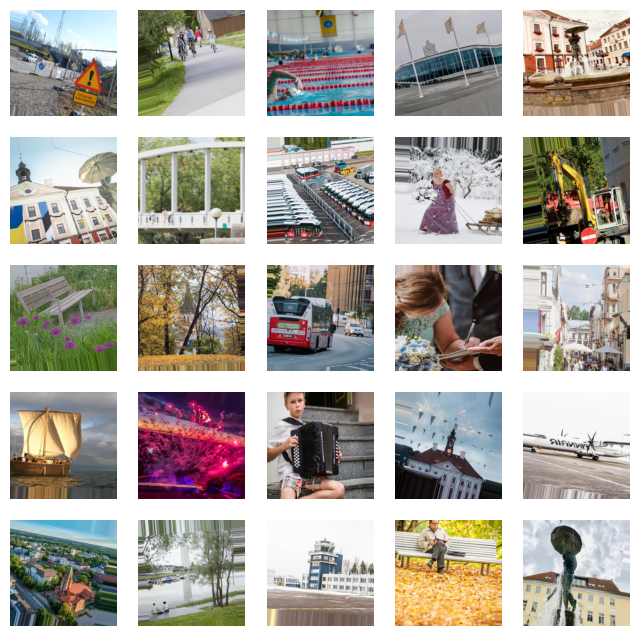

In [19]:
# Visualise augmented images
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=25):
    # Show 25 images
    for i in range(0, 25):
        plt.subplot(5, 5, 1 + i)
        plt.imshow(X_batch[i])
        plt.axis('off')
    # show the plot
    plt.show()
    break

In [20]:
# ResNet50

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(300,300,3),
                   pooling='avg',
                   classes=92,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
# Use sigmoid because multi-label classification. Softmax would be used with multi-class
resnet_model.add(Dense(92, kernel_initializer= tf.keras.initializers.GlorotUniform(seed=111), activation='sigmoid'))
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 92)                47196     
                                                                 
Total params: 24,683,996
Trainable params: 1,096,284
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
resnet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.Precision(),
                      #tfa.metrics.HammingLoss(mode='multilabel'),
                      tfa.metrics.F1Score(num_classes=92)], 
                      optimizer=optimizers.Adam(learning_rate=0.001))

# Model with image augmentation
history = resnet_model.fit(datagen.flow(X_train, np.array(y_train), batch_size=64),
                    steps_per_epoch=X_train.shape[0]//64,
                    epochs=25,
                    verbose=1,
                    validation_data=(X_val, np.array(y_val)))

# Save model
resnet_model.save('Kea_resnet_02_augm.hdf5')

Epoch 1/25
2/2 [==============================] - 76s 36s/step - loss: 0.6365 - binary_accuracy: 0.6654 - recall_4: 0.2878 - precision_4: 0.0400 - f1_score: 5.4805e-04 - val_loss: 0.3340 - val_binary_accuracy: 0.9198 - val_recall_4: 0.0230 - val_precision_4: 0.0278 - val_f1_score: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 66s 36s/step - loss: 0.2936 - binary_accuracy: 0.9306 - recall_4: 0.0189 - precision_4: 0.0325 - f1_score: 8.2345e-04 - val_loss: 0.2015 - val_binary_accuracy: 0.9550 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_f1_score: 0.0036
Epoch 3/25
2/2 [==============================] - 64s 28s/step - loss: 0.1928 - binary_accuracy: 0.9546 - recall_4: 0.0000e+00 - precision_4: 0.0000e+00 - f1_score: 0.0081 - val_loss: 0.1735 - val_binary_accuracy: 0.9545 - val_recall_4: 0.0000e+00 - val_precision_4: 0.0000e+00 - val_f1_score: 0.0054
Epoch 4/25
2/2 [==============================] - 60s 35s/step - loss: 0.1695 - binary_accuracy: 0.9560 - rec

Text(0.5, 1.0, 'f1_score: harmonic mean of precision and recall')

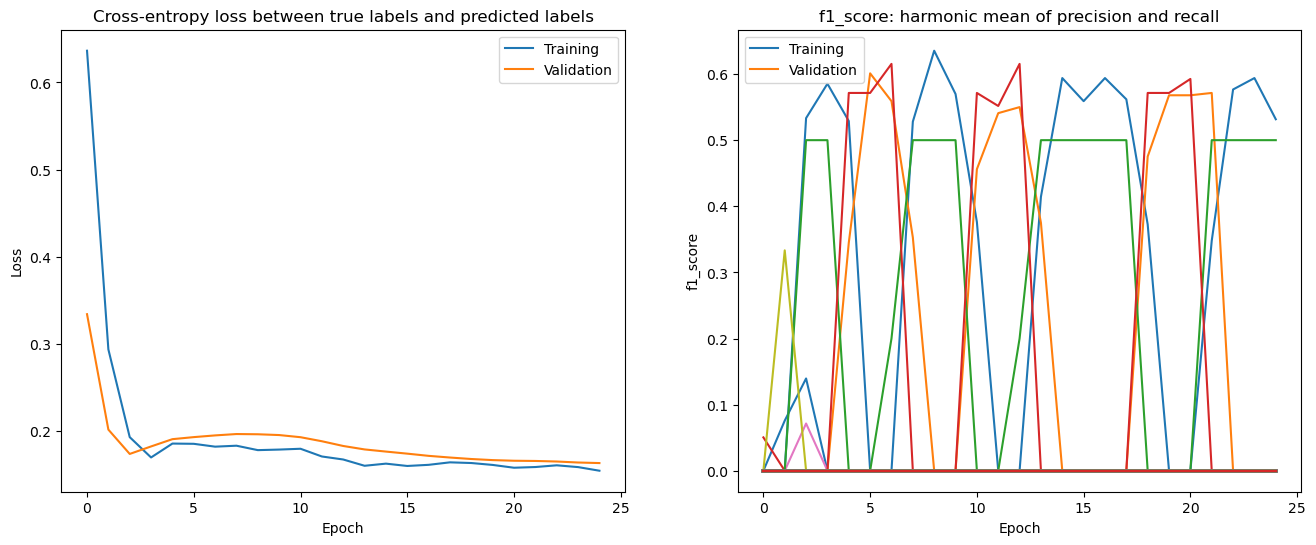

In [24]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Cross-entropy loss between true labels and predicted labels')

plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend(['Training', 'Validation'])
plt.title('f1_score: harmonic mean of precision and recall')

Text(0.5, 1.0, 'Recall: ratio of how many of the actual labels were predicted')

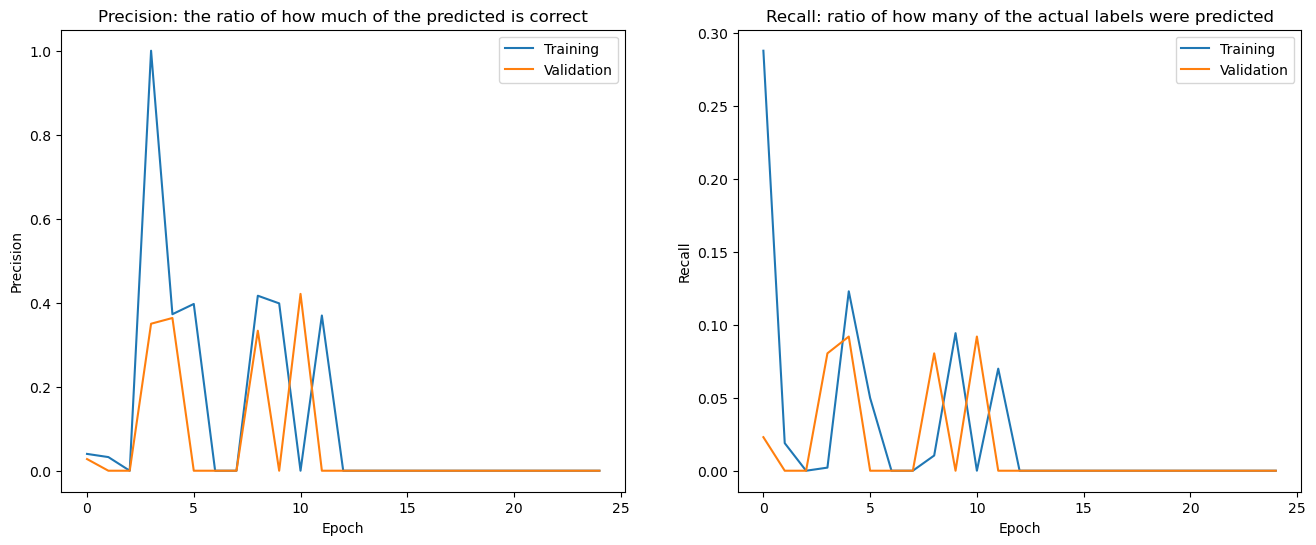

In [26]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training', 'Validation'])
plt.title('Precision: the ratio of how much of the predicted is correct')

plt.subplot(1, 2, 2)
plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training', 'Validation'])
plt.title('Recall: ratio of how many of the actual labels were predicted')

In [ ]:
# Model evaluation
# TO-DO